# **Data Mining and Machine Learning - Team Tissot**

**Detecting the difficulty level of French texts**

**Word2Vec**

In this notebook we attempted to achieve greater accuracy by using Word2Vec


#  1. Importing packages and data

In [ ]:
# Importing packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from wordcloud import WordCloud   
sns.set_style("whitegrid")

# import some additional packages for training models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords  
nltk.download('punkt')

# import tqdm (progress bar)
from tqdm import tqdm

# import files to download .csv
from google.colab import files

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Importing packages for tokenization

# Install and update spaCy
!pip install -U spacy

# Download the french language model
!python -m spacy download fr_core_news_sm

In [ ]:
# Import required packages from spacy
import spacy
from spacy import displacy

#Load French language model
sp = spacy.load("fr_core_news_sm")

> Additional custom functions from our github repo. [Documentation](https://github.com/danieldovale/DMML2022_Tissot/blob/main/documents/CustomFunctionsDocumentation.ipynb)


In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests

In [ ]:
url = 'https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/code/custom_functions.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('custom_functions.py', 'w') as f:
    f.write(r.text)

# now we can import
import custom_functions as cfun

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# training data:
dfTrain = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/training_data.csv", index_col='id')

# unlabeled test data:
dfTest = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/unlabelled_test_data.csv", index_col='id')

---

# 2. Setting up Word2Vec

First, let's define a spacy tokenizer

In [ ]:
import string

def spacy_tokenizer(sentence):

    doc = sp(sentence)  
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in doc ]
    return mytokens

> This tokenizer transform words into tokens that are lowercase and lemmatized if the word is not a pronoun

Next, let's gather some additional information about the sentences using our [custom function](https://github.com/danieldovale/DMML2022_Tissot/blob/main/documents/CustomFunctionsDocumentation.ipynb)





In [ ]:
dfTrainInfo = cfun.get_info(dfTrain) 

100%|██████████| 4800/4800 [01:11<00:00, 67.55it/s]


In [ ]:
dfTrainInfo

,text_length,number_of_sentences,number_of_words,sent_length_avg,words_length_avg,number_of_words_after_lemma_stop,longest_word_size
0,255,1,38,38.0,6.710526,23,16
1,62,1,12,12.0,5.166667,5,8
2,66,1,13,13.0,5.076923,6,8
3,40,1,8,8.0,5.000000,3,6
4,209,1,36,36.0,5.805556,19,11
...,...,...,...,...,...,...,...
4795,165,1,26,26.0,6.346154,12,12
4796,118,1,21,21.0,5.619048,9,10
4797,80,1,13,13.0,6.153846,6,11
4798,226,1,32,32.0,7.062500,16,16


> `text_length`: Character length of the text  
> `number_of_sentences`: How many sentences are in the text   
> `number_of_words`:  Number of words in text  
> `sent_length_avg`: Average number of words per sentence       
> `words_length_avg`: Average length of the words        
> `number_of_words_after_lemma_stop`: Number of words remaining after stop
>
>  words removal and lemmatization  
> `longest_word_size`: Size of the largest word in the sentence

**Tokenizing every words in dfTrain and dfTest to feed it as vocabulary to Word2Vec**

In [ ]:
# Tokenizing texts in dfTrain
processed_texts = []
for text in tqdm(dfTrain["sentence"]):
  processed_text = spacy_tokenizer(text)
  processed_texts.append(processed_text)

100%|██████████| 4800/4800 [01:06<00:00, 71.81it/s] 


In [ ]:
len(processed_texts)

4800

In [ ]:
# Tokenize texts in dfTrain
processed_texts_test = []
for text in tqdm(dfTest["sentence"]):
  processed_text_test = spacy_tokenizer(text)
  processed_texts_test.append(processed_text_test)

100%|██████████| 1200/1200 [00:12<00:00, 94.00it/s]


In [ ]:
len(processed_texts_test)

1200

In [ ]:
# Merging both lists of tokens
processed_texts_both = processed_texts + processed_texts_test

In [ ]:
len(processed_texts_both)

6000

In [ ]:
# import package for Word2Vec
import gensim

In [ ]:
# Necessary function to set a fixed random state to Word2Vec
def hash(astring):
   return ord(astring[0])

In [ ]:
# Building Word2Vec model
model = gensim.models.Word2Vec(size=512, window=10, min_count=1, workers=1, seed = 0, hashfxn=hash)
model.build_vocab(processed_texts_both)
# train model on preprocessed sentences
model.train(processed_texts_both, total_examples=len(processed_texts_both), epochs=100)

(8322315, 12880800)

**Building dataframe with vectors**

In [ ]:
# Applying Word2Vec vectorizer to every sentence in dfTrain
vectors = []
for sent in tqdm(processed_texts):
    if len(sent) == 0:
      vectors.append(np.zeros(128))
    else:
      vectors.append(sum(model[token] for token in sent)/len(sent))


  0%|          | 0/4800 [00:00<?, ?it/s]<ipython-input-31-690c4e85c5e0>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 4800/4800 [00:00<00:00, 7092.75it/s]


In [ ]:
# vectors to Dataframe
dfVectors = pd.DataFrame(vectors)

In [ ]:
# Concatenating vectors and info dataframes
dfFinal = pd.concat([dfVectors, dfTrainInfo], axis = 1)

In [ ]:
dfFinal

,0,1,2,3,4,5,6,7,8,9,...,509,510,511,text_length,number_of_sentences,number_of_words,sent_length_avg,words_length_avg,number_of_words_after_lemma_stop,longest_word_size
0,-0.264702,-0.054860,0.008756,-0.019533,-0.098331,0.196590,-0.306934,-0.271492,0.299544,-0.026537,...,0.260990,-0.077786,0.063096,255,1,38,38.0,6.710526,23,16
1,-0.264473,-0.216078,-0.027391,-0.047066,-0.198998,0.532014,0.274604,0.385479,-0.096584,0.040077,...,-0.255355,-0.447171,-0.071805,62,1,12,12.0,5.166667,5,8
2,-0.239763,0.159461,0.030382,0.116563,-0.261869,0.347780,-0.384190,-0.334554,0.470524,0.097451,...,0.108303,-0.050763,0.125373,66,1,13,13.0,5.076923,6,8
3,0.258340,0.209802,-0.105560,0.037034,-0.341441,0.300095,-0.178567,-0.065097,-0.003501,0.051051,...,-0.277259,-0.135898,-0.257274,40,1,8,8.0,5.000000,3,6
4,0.071009,-0.090257,-0.456437,0.306881,-0.253829,0.368368,-0.001610,-0.022038,-0.018982,-0.004057,...,0.095305,0.129927,-0.002473,209,1,36,36.0,5.805556,19,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,-0.087123,0.071570,0.229351,-0.109172,0.217795,0.272276,0.023175,-0.324243,0.156078,-0.049463,...,-0.186852,-0.171943,0.052046,165,1,26,26.0,6.346154,12,12
4796,0.072282,0.075880,0.139354,0.131627,0.079980,0.326707,0.241352,-0.148232,0.090060,-0.264072,...,-0.051814,-0.041908,0.131595,118,1,21,21.0,5.619048,9,10
4797,0.211027,0.076704,0.090963,-0.079126,0.100133,0.395611,0.196953,0.269708,0.222744,0.029607,...,0.228088,0.054794,0.021562,80,1,13,13.0,6.153846,6,11
4798,-0.440582,-0.002045,-0.135184,0.026540,-0.060260,0.174795,0.117925,-0.244291,0.130200,0.034243,...,0.049387,-0.296686,-0.074006,226,1,32,32.0,7.062500,16,16


# 3. Training a model using Word2Vec and LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# train logistic regression model
X = dfFinal
y = dfTrain['difficulty']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fitting using a LogisticRegression
clf = LogisticRegression(max_iter=10000, random_state = 0)
clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LogisticRegression(max_iter=10000, random_state=0)

In [ ]:
y_pred_w2vLR = clf.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,accuracy,precision,recall,f1 score
results,0.499,0.5017,0.499,0.4949


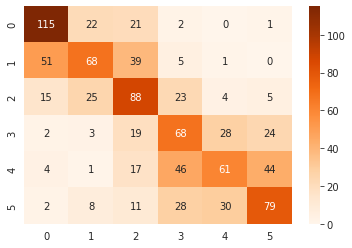

In [ ]:
cfun.evaluate(y_test, y_pred_w2vLR)

In [ ]:
cfun.class_accuracy(y_test, y_pred_w2vLR)

A1: 0.71%
A2: 0.41%
B1: 0.55%
B2: 0.47%
C1: 0.35%
C2: 0.50%


> This model performed slightly better than the simple Logistic Regression, but it could be improved by tuning the Word2Vec parameters. 

# 4. Searching Best Word2Vec Parameters with Logistic Regression

Creating a list of different parameters combinations for word2vec 

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    size = [32,128,256,512]
    window = [10,50,100]
    epochs = [10,50,100,300]

    
    # Create config instances
    for n in size:
        for i in window:
            for j in epochs:
                cfg = [n, i, j]
                models.append(cfg)
    return models
configs = configs()
configs

In [ ]:
# Looping through every Word2Vec configuration set by configs, and train the data with a Logistic Regression

result = []
for config in tqdm(configs):


    model = gensim.models.Word2Vec(size=config[0], window=config[1], min_count=1, workers=1, seed = 0, hashfxn=hash)
    model.build_vocab(processed_texts_both)
    # train model on preprocessed sentences
    model.train(processed_texts_both, total_examples=len(processed_texts_both), epochs=config[2])

    #vectorize using word2vec
    vectors = []
    for sent in processed_texts:
        if len(sent) == 0:
          vectors.append(np.zeros(config[0]))
        else:
          vectors.append(sum(model[token] for token in sent)/len(sent))

    #final dataframe
    dfVectors = pd.DataFrame(vectors)
    dfFinal = pd.concat([dfVectors, dfTrainInfo], axis = 1)

    #Logistic Regression
    # train logistic regression model
    X = dfFinal
    y = dfTrain['difficulty']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    clf = LogisticRegression(max_iter=10000, random_state = 0)
    clf.fit(X_train, y_train)

    #predictions
    y_pred = clf.predict(X_test)
    print("CONFIG: ", config)
    print(accuracy_score(y_test, y_pred))
    print("\n-----------------------")
    result.append([config, accuracy_score(y_test, y_pred)])

In [ ]:
result.sort(key=lambda x: x[1], reverse=True)
word2vecTuningDF = (pd.DataFrame(result)).rename(columns = {0:'config', 1: 'accuracy'})

Taking a look at the best results in terms of accuracy:

In [ ]:
word2vecTuningDF.head()

,config,accuracy
0,"[128, 50, 300]",0.521875
1,"[256, 10, 300]",0.510417
2,"[32, 10, 300]",0.507292
3,"[512, 10, 300]",0.503125
4,"[128, 10, 300]",0.500000


**Fitting the model once more with the best word2vec parameters**

In [ ]:
model = gensim.models.Word2Vec(size=128, window=50, min_count=1, workers=1, seed = 0, hashfxn=hash)
model.build_vocab(processed_texts_both)
# train model on preprocessed sentences
model.train(processed_texts_both, total_examples=len(processed_texts_both), epochs=300)

#vectorize using word2vec
vectors = []
for sent in processed_texts:
    if len(sent) == 0:
      vectors.append(np.zeros(config[0]))
    else:
      vectors.append(sum(model[token] for token in sent)/len(sent))

#final dataframe
dfVectors = pd.DataFrame(vectors)
dfFinal = pd.concat([dfVectors, dfTrainInfo], axis = 1)

#Logistic Regression
# train logistic regression model
X = dfFinal
y = dfTrain['difficulty']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = LogisticRegression(max_iter=10000, random_state = 0)
clf.fit(X_train, y_train)

<ipython-input-75-80ae33e827aa>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors.append(sum(model[token] for token in sent)/len(sent))
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LogisticRegression(max_iter=10000, random_state=0)

In [ ]:
y_pred_w2v = clf.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,accuracy,precision,recall,f1 score
results,0.5219,0.5218,0.5219,0.5205


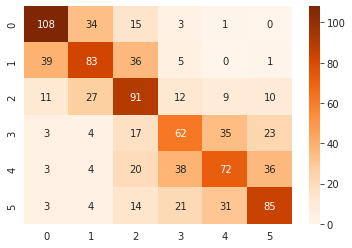

In [ ]:
cfun.evaluate(y_test, y_pred_w2v)

In [ ]:
cfun.class_accuracy(y_test, y_pred_w2v)

A1: 0.67%
A2: 0.51%
B1: 0.57%
B2: 0.43%
C1: 0.42%
C2: 0.54%


Tuning the word2vec parameters improved the accuracy by around 2%

**Predictions on** `unlabelled_test_data.csv` **(dfTest)**

First, let's the fit on the whole data

In [ ]:
clf.fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LogisticRegression(max_iter=10000, random_state=0)

Next, we have to apply on dfTest the same transformations we applied on dfTrain

In [ ]:
# Vectorizing dfTest sentences
vectors_test = []
for sent in processed_texts_test:
    if len(sent) == 0:
      vectors_test.append(np.zeros(128))
    else:
      vectors_test.append(sum(model[token] for token in sent)/len(sent))

<ipython-input-85-3f032bda1e60>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors_test.append(sum(model[token] for token in sent)/len(sent))


In [ ]:
# Vectors to dataframe
dfVectorsTest = pd.DataFrame(vectors_test)

In [ ]:
# Getting additional information on dfTest using our custom function
dfTestInfo = cfun.get_info(dfTest)

100%|██████████| 1200/1200 [00:11<00:00, 105.68it/s]


In [ ]:
# Concatenating the 2 dataframes
dfFinalTest = pd.concat([dfVectorsTest, dfTestInfo], axis = 1)

Predicting the difficulty

In [ ]:
# Predicting dfTest sentences difficulty
y_pred_test = clf.predict(dfFinalTest)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(y_pred_test, "w2v_tuned_LR", False)

,difficulty
id,
0,C2
1,A2
2,B1
3,B1
4,C2


**Submission score: 0.46416**

> The submission accuracy is around 6% lower than the accuracy on the test set. 

> This could indicate that the model is overfitting to the test set and is not generalizing well to unseen data. A possible solution would be to use ensemble classifiers. Ensemble models are a type of model that combines the predictions of multiple individual models to make a final prediction. Ensemble models can often improve the generalization performance of a model by reducing overfitting. 

> We tried using ensemble classifiers in [this notebook.](https://github.com/danieldovale/DMML2022_Tissot/blob/main/code/Ensemble_W2V.ipynb)
